## Cell 1: Import Data

In [1]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train (4).csv


## Cell 2: Import libraries and dependencies

In [2]:
%pip install shap
%pip install forex-python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from forex_python.converter import CurrencyRates
import shap
import joblib

## Cell 3: Data Loading

In [54]:
# Load the CSV file
file_path = 'train.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(data.head())

# Display summary statistics of the dataframe
data.describe(include='all')

                               Name    Location  Year  Kilometers_Driven  \
0            Maruti Wagon R LXI CNG      Mumbai  2010              72000   
1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015              41000   
2                      Honda Jazz V     Chennai  2011              46000   
3                 Maruti Ertiga VDI     Chennai  2012              87000   
4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013              40670   

  Fuel_Type Transmission Owner_Type     Mileage   Engine      Power  Seats  \
0       CNG       Manual      First  26.6 km/kg   998 CC  58.16 bhp    5.0   
1    Diesel       Manual      First  19.67 kmpl  1582 CC  126.2 bhp    5.0   
2    Petrol       Manual      First   18.2 kmpl  1199 CC   88.7 bhp    5.0   
3    Diesel       Manual      First  20.77 kmpl  1248 CC  88.76 bhp    7.0   
4    Diesel    Automatic     Second   15.2 kmpl  1968 CC  140.8 bhp    5.0   

   New_Price  Price  
0        NaN   1.75  
1        NaN  12.50  
2  8.61 

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
count,6019,6019,6019.000000,6.019000e+03,6019,6019,6019,6017,5983,5983,5977.000000,824,6019.000000
unique,1876,11,NaN,NaN,5,2,4,442,146,372,NaN,540,NaN
top,Mahindra XUV500 W8 2WD,Mumbai,NaN,NaN,Diesel,Manual,First,18.9 kmpl,1197 CC,74 bhp,NaN,95.13 Lakh,NaN
freq,49,790,NaN,NaN,3205,4299,4929,172,606,235,NaN,6,NaN
mean,NaN,NaN,2013.358199,5.873838e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.278735,NaN,9.479468
std,NaN,NaN,3.269742,9.126884e+04,NaN,NaN,NaN,NaN,NaN,NaN,0.808840,NaN,11.187917
min,NaN,NaN,1998.000000,1.710000e+02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.440000
25%,NaN,NaN,2011.000000,3.400000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,3.500000
50%,NaN,NaN,2014.000000,5.300000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,5.640000
75%,NaN,NaN,2016.000000,7.300000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,9.950000


## Cell 4: Data Cleaning

In [55]:
# Display general information about the dataframe
data.info()

# Display the number of missing values in each column
print(data.isnull().sum())

# Fill missing values with mode or median as appropriate
data['Mileage'] = data['Mileage'].fillna(data['Mileage'].mode()[0])
data['Engine'] = data['Engine'].fillna(data['Engine'].mode()[0])
data['Power'] = data['Power'].fillna(data['Power'].mode()[0])
data['Seats'] = data['Seats'].fillna(data['Seats'].median())

# Drop 'New_Price' column due to many missing values
data = data.drop(columns=['New_Price'])

# Convert 'Mileage', 'Engine', and 'Power' to numeric after removing units
data['Mileage'] = data['Mileage'].str.extract('(\d+\.\d+)')[0].astype(float)
data['Engine'] = data['Engine'].str.extract('(\d+)')[0].astype(float)
data['Power'] = data['Power'].str.extract('(\d+\.\d+|\d+)')[0].astype(float)

# Add 'Age' column based on the 'Year' column
current_year = 2024
data['Age'] = current_year - data['Year']

# Convert categorical variables to dummy variables
data = pd.get_dummies(data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

# Verify cleaned data
data.info()
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_

## Cell 5: Exploratory Data Analysis

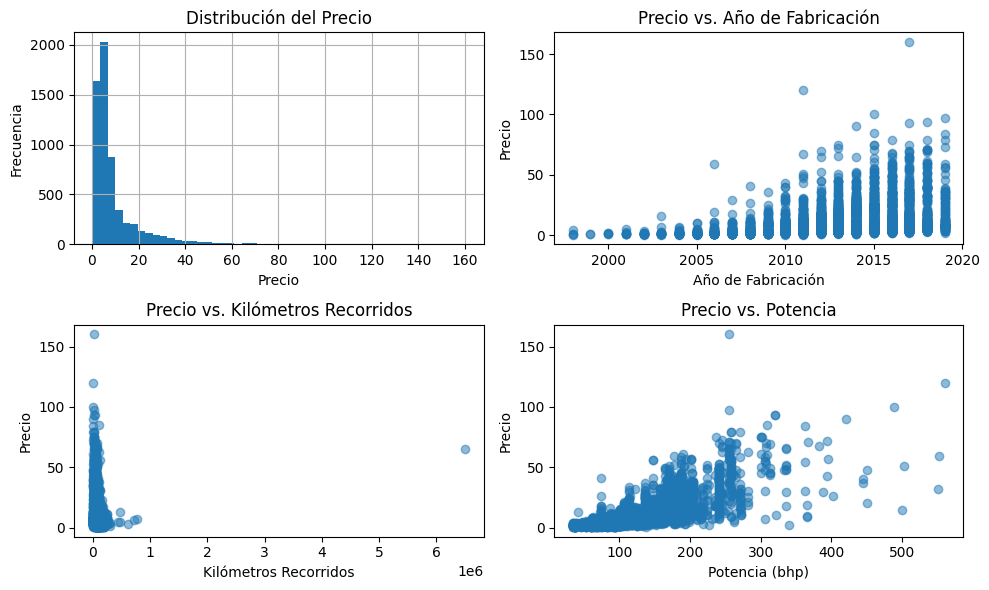

In [56]:
# Configure figure size
plt.figure(figsize=(10, 6))

# Plot distribution of prices
plt.subplot(2, 2, 1)
data['Price'].hist(bins=50)
plt.title('Distribución del Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Plot Price vs. Year of Manufacturing
plt.subplot(2, 2, 2)
plt.scatter(data['Year'], data['Price'], alpha=0.5)
plt.title('Precio vs. Año de Fabricación')
plt.xlabel('Año de Fabricación')
plt.ylabel('Precio')

# Plot Price vs. Kilometers Driven
plt.subplot(2, 2, 3)
plt.scatter(data['Kilometers_Driven'], data['Price'], alpha=0.5)
plt.title('Precio vs. Kilómetros Recorridos')
plt.xlabel('Kilómetros Recorridos')
plt.ylabel('Precio')

# Plot Price vs. Power
plt.subplot(2, 2, 4)
plt.scatter(data['Power'], data['Price'], alpha=0.5)
plt.title('Precio vs. Potencia')
plt.xlabel('Potencia (bhp)')
plt.ylabel('Precio')

# Adjust layout
plt.tight_layout()
plt.show()

## Cell 6: Data Splitting

In [57]:
# Select features and target variable
X = data.drop(columns=['Name', 'Location', 'Price'])
y = data['Price']

# Fill missing values in features if any
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cell 7: Model Training and Evaluation

In [58]:
# Train the Linear Regression model with log-transformed target
model = LinearRegression()
model.fit(X_train, y_train)  # No log transformation

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 4.016023428427116
MSE: 64.97709361399008
RMSE: 8.060837029365503
R2: 0.47198633267261647


## Cell 8: Linear Regression Model Slope and Intercept

In [59]:
# Display the slope and intercept for Linear Regression
print(f"Linear Regression Model's slope: {model.coef_}")
print(f"Linear Regression Model's y-intercept: {model.intercept_}")
print(f"Linear Regression Model's formula: y = {model.intercept_} + {model.coef_} * X")

# Example prediction using the formula
feature_value = 7  # Replace with an appropriate feature value for your data
predicted_price = model.intercept_ + model.coef_[0] * feature_value
print(f"Predicted price for feature value {feature_value}: ${predicted_price:.2f}")

Linear Regression Model's slope: [ 4.58397088e-01 -2.32678323e-05 -2.64482886e-01  6.81435061e-04
  1.21222890e-01 -1.12756498e+00 -4.58397088e-01 -6.12348598e-01
  6.04737121e+00  1.08279999e+00 -3.93243083e+00 -2.62981211e+00
  3.49364281e+00 -1.18945831e-01  1.42183326e+00]
Linear Regression Model's y-intercept: -907.2304992907402
Linear Regression Model's formula: y = -907.2304992907402 + [ 4.58397088e-01 -2.32678323e-05 -2.64482886e-01  6.81435061e-04
  1.21222890e-01 -1.12756498e+00 -4.58397088e-01 -6.12348598e-01
  6.04737121e+00  1.08279999e+00 -3.93243083e+00 -2.62981211e+00
  3.49364281e+00 -1.18945831e-01  1.42183326e+00] * X
Predicted price for feature value 7: $-904.02


## Cell 9: Feature Importance Analysis

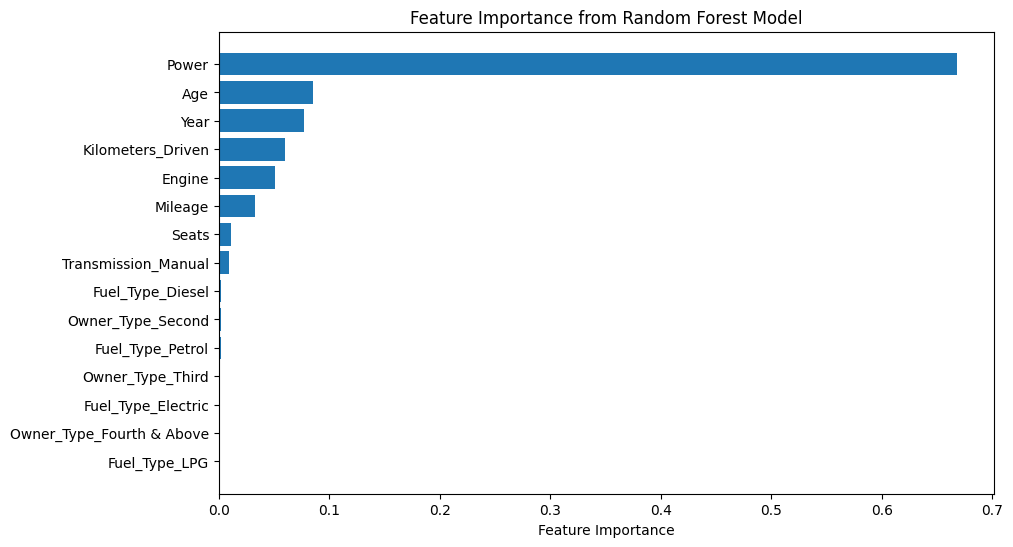

In [60]:
# Train a Random Forest model to determine feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

## Cell 10: Advanced Model Training

In [61]:
# Clean and scale the data
def clean_and_scale_data(X, y):
    # Convert X back to DataFrame
    X_cleaned = pd.DataFrame(X, columns=data.drop(columns=['Name', 'Location', 'Price']).columns)
    y_cleaned = pd.Series(y, name='Price')

    # Combine X and y for consistent filtering
    combined_df = pd.concat([X_cleaned, y_cleaned], axis=1)

    # Remove outliers (e.g., prices > $100,000 or <= 0)
    combined_df = combined_df[(combined_df['Price'] > 0) & (combined_df['Price'] < 100000)]

    # Separate X and y again
    X_cleaned = combined_df.drop(columns=['Price'])
    y_cleaned = combined_df['Price']

    return X_cleaned, y_cleaned

# Clean the training and test data
X_train_cleaned, y_train_cleaned = clean_and_scale_data(X_train, y_train)
X_test_cleaned, y_test_cleaned = clean_and_scale_data(X_test, y_test)

# Create a pipeline for scaling and model training
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model_pipeline.fit(X_train_cleaned, y_train_cleaned)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test_cleaned)

# Evaluate the model
mae = mean_absolute_error(y_test_cleaned, y_pred)
mse = mean_squared_error(y_test_cleaned, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cleaned, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

# Save the model pipeline
joblib.dump((model_pipeline, X_train_cleaned.columns), 'best_rf_model_with_columns.pkl')

MAE: 1.7197603071112169
MSE: 17.682418341527764
RMSE: 4.205046770432853
R2: 0.8563100003950187


['best_rf_model_with_columns.pkl']

## Cell 11: Hyperparameter Tuning

In [62]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 1.7065864049398827
MSE: 16.119644005858216
RMSE: 4.014927646403882
R2: 0.8690093404591352


## Cell 12: Cross-Validation

In [63]:
# Function to evaluate model using cross-validation
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()

# Evaluate Linear Regression
lr = LinearRegression()
lr_mean_rmse, lr_std_rmse = evaluate_model(lr, X_train, y_train)
print(f"Linear Regression: Mean RMSE = {lr_mean_rmse:.2f}, Std RMSE = {lr_std_rmse:.2f}")

# Evaluate Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mean_rmse, rf_std_rmse = evaluate_model(rf, X_train, y_train)
print(f"Random Forest: Mean RMSE = {rf_mean_rmse:.2f}, Std RMSE = {rf_std_rmse:.2f}")

# Evaluate XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb_mean_rmse, xgb_std_rmse = evaluate_model(xgb, X_train, y_train)
print(f"XGBoost: Mean RMSE = {xgb_mean_rmse:.2f}, Std RMSE = {xgb_std_rmse:.2f}")

Linear Regression: Mean RMSE = 6.14, Std RMSE = 0.76
Random Forest: Mean RMSE = 3.81, Std RMSE = 0.88
XGBoost: Mean RMSE = 3.91, Std RMSE = 0.87


## Cell 13: Making Predictions on New Data

In [64]:
# Load the model pipeline
pipeline_with_columns = joblib.load('best_rf_model_with_columns.pkl')
loaded_pipeline, loaded_columns = pipeline_with_columns

# Ensure the features used during training are consistent
def preprocess_features_for_model(X, columns):
    # Ensure the correct dummy columns are added
    X = pd.DataFrame(X, columns=columns)
    return X

# Preprocess the test data to match the training features
X_test_preprocessed = preprocess_features_for_model(X_test, loaded_columns)

# Verify the loaded model
y_pred = loaded_pipeline.predict(X_test_preprocessed)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Loaded Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

Loaded Model - MAE: 1.7197603071112169, MSE: 17.682418341527764, RMSE: 4.205046770432853, R2: 0.8563100003950187


## Cell 14: Model Persistence

In [65]:
# Clean and scale the data
def clean_and_scale_data(X, y, scaler=None):
    X_cleaned = X.copy()
    y_cleaned = y.copy()

    # Remove outliers (e.g., prices > $100,000 or <= 0)
    y_cleaned = y_cleaned[(y_cleaned > 0) & (y_cleaned < 100000)]
    X_cleaned = X_cleaned.loc[y_cleaned.index]

    # Scale the features
    if scaler is None:
        scaler = StandardScaler()
        X_cleaned_scaled = scaler.fit_transform(X_cleaned)
    else:
        X_cleaned_scaled = scaler.transform(X_cleaned)

    return X_cleaned_scaled, y_cleaned, scaler

# Clean and scale the training and test data
X_train_cleaned_scaled, y_train_cleaned, scaler = clean_and_scale_data(X_train, y_train)
X_test_cleaned_scaled, y_test_cleaned, _ = clean_and_scale_data(X_test, y_test, scaler)

# Create a pipeline for scaling and model training
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train_cleaned_scaled, y_train_cleaned)

# Save the pipeline and feature names
joblib.dump((pipeline, X_train_cleaned_scaled), 'best_rf_model_with_columns.pkl')

['best_rf_model_with_columns.pkl']

## Cell 15: Prediction Visualization

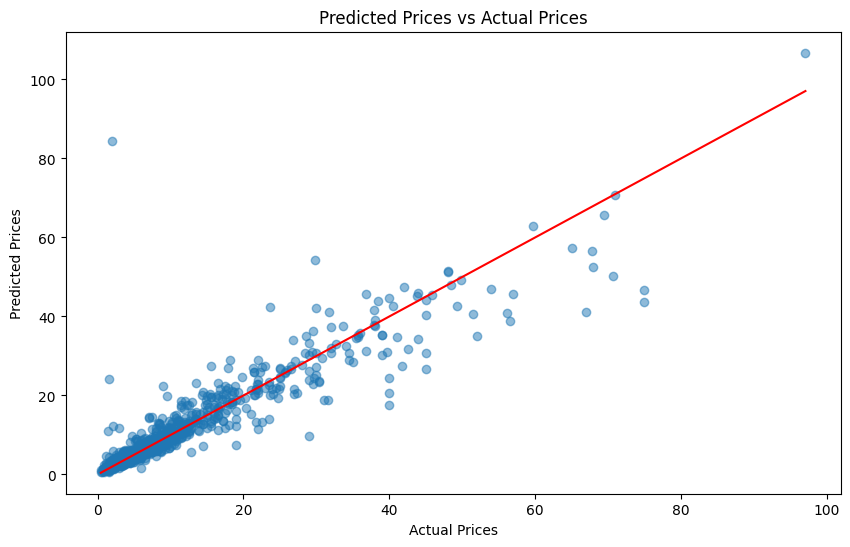

In [68]:
# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.title('Predicted Prices vs Actual Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

## Cell 16: Feature Engineering

In [69]:
# Load the model pipeline
pipeline_with_columns = joblib.load('best_rf_model_with_columns.pkl')
loaded_pipeline, loaded_columns = pipeline_with_columns

# Check if 'Year' column is present before creating new features
if 'Year' in data.columns:
    data['Age'] = 2024 - data['Year']
    data['Mileage_per_Year'] = data['Kilometers_Driven'] / data['Age']
    data = data.drop(columns=['Year'])  # Drop 'Year' as it's now represented by 'Age'

# Convert categorical variables to dummy variables if they exist
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type']
for column in categorical_columns:
    if column in data.columns:
        data = pd.get_dummies(data, columns=[column], drop_first=True)

# Ensure all expected columns are in the data
expected_columns = [col[0] if isinstance(col, np.ndarray) else col for col in loaded_columns]  # Convert to hashable type
for col in expected_columns:
    if col not in data.columns:
        data[col] = 0

# Re-split the data
X = data.drop(columns=['Name', 'Location', 'Price'])
y = data['Price']

# Ensure no NaN values in X
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cell 17: Model Comparison Visualization

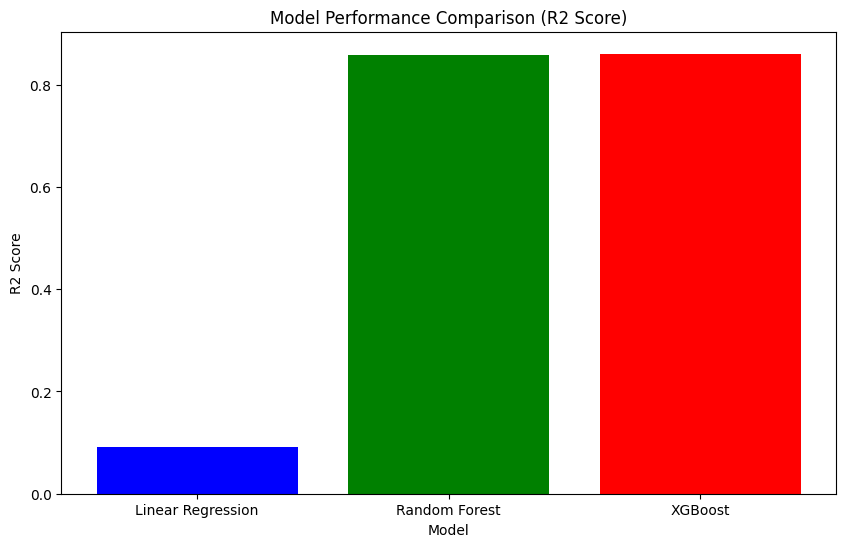

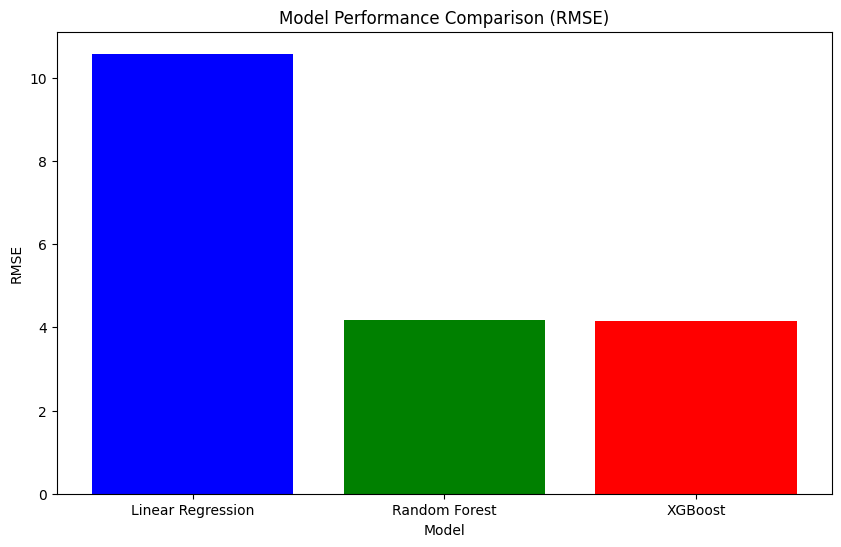

In [70]:
# Ensure all feature names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Ensure results_cleaned is defined
# Define models
models_cleaned = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results_cleaned = {}
for model_name, model in models_cleaned.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae_cleaned = mean_absolute_error(y_test, y_pred)
    mse_cleaned = mean_squared_error(y_test, y_pred)
    rmse_cleaned = np.sqrt(mse_cleaned)
    r2_cleaned = r2_score(y_test, y_pred)
    results_cleaned[model_name] = {'MAE': mae_cleaned, 'MSE': mse_cleaned, 'RMSE': rmse_cleaned, 'R2': r2_cleaned}

# Plotting model performance comparison
results_df_cleaned = pd.DataFrame(results_cleaned).T

plt.figure(figsize=(10, 6))
plt.bar(results_df_cleaned.index, results_df_cleaned['R2'], color=['blue', 'green', 'red'])
plt.title('Model Performance Comparison (R2 Score)')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(results_df_cleaned.index, results_df_cleaned['RMSE'], color=['blue', 'green', 'red'])
plt.title('Model Performance Comparison (RMSE)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

## Cell 18: Residual Analysis

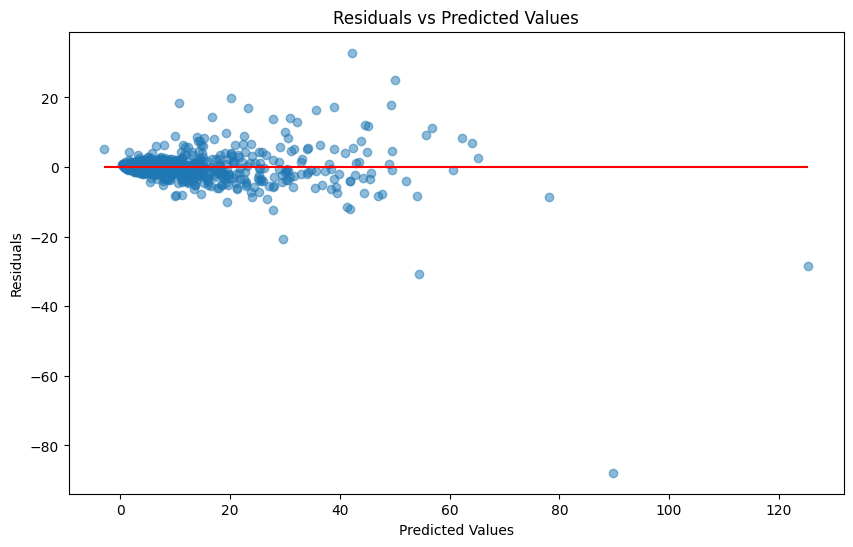

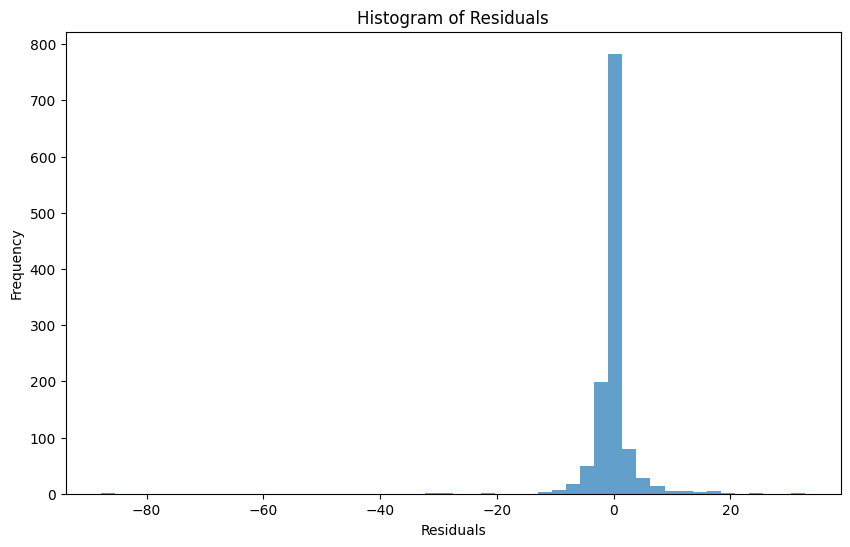

In [71]:
# Residual analysis for the best model (Random Forest in this case)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='red')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Cell 19: Advanced Feature Engineering

In [72]:
# Ensure all feature names are strings
X.columns = X.columns.astype(str)

# Creating polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the polynomial features data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train a model on the polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_poly)
y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate the polynomial features model
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)

print(f"Polynomial Features Model - MAE: {mae_poly}, MSE: {mse_poly}, RMSE: {rmse_poly}, R2: {r2_poly}")

Polynomial Features Model - MAE: 3.7238407658869255, MSE: 1991.377046886117, RMSE: 44.62484786401089, R2: -15.182230368819127


## Cell 20: Time-Series Analysis

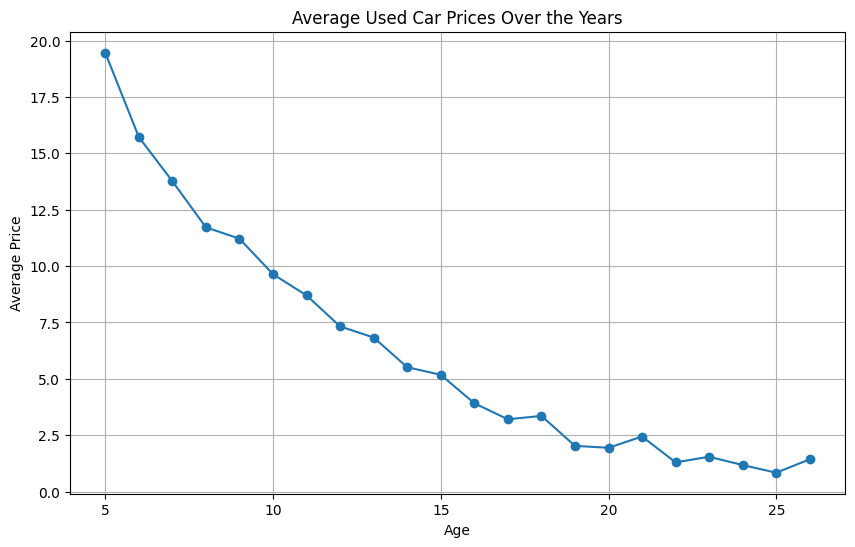

Age
5     102
6     298
7     587
8     741
9     744
10    797
11    649
12    580
13    466
14    342
15    198
16    174
17    125
18     78
19     57
20     31
21     17
22     15
23      8
24      4
25      2
26      4
Name: count, dtype: int64
count    6019.000000
mean        9.479468
std        11.187917
min         0.440000
25%         3.500000
50%         5.640000
75%         9.950000
max       160.000000
Name: Price, dtype: float64


In [76]:
# Calculate the average price per age
avg_price_per_age = data.groupby('Age')['Price'].mean()

# Plot the average prices per age
plt.figure(figsize=(10, 6))
plt.plot(avg_price_per_age.index, avg_price_per_age.values, marker='o')
plt.title('Average Used Car Prices Over the Years')
plt.xlabel('Age')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

print(data['Age'].value_counts().sort_index())
print(data['Price'].describe())

## Cell 21: Clustering Analysis

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataset
data['Cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['Age'], data['Price'], c=data['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering of Used Cars by Age and Price')
plt.xlabel('Age')
plt.ylabel('Price')
plt.colorbar(label='Cluster')
plt.show()

## Cell 22: Feature Selection

In [74]:
# Use RFE with a Random Forest model
selector = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=10)
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)

# Train a model using only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model_rf_selected = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_selected.fit(X_train_selected, y_train)

# Evaluate the model
y_pred_selected = model_rf_selected.predict(X_test_selected)
mae_selected = mean_absolute_error(y_test, y_pred_selected)
mse_selected = mean_squared_error(y_test, y_pred_selected)
rmse_selected = np.sqrt(mse_selected)
r2_selected = r2_score(y_test, y_pred_selected)

print(f"Selected Features Model - MAE: {mae_selected}, MSE: {mse_selected}, RMSE: {rmse_selected}, R2: {r2_selected}")

Selected Features: Index(['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Age',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Transmission_Manual',
       'Mileage_per_Year'],
      dtype='object')
Selected Features Model - MAE: 1.7216206474120659, MSE: 17.312928796267027, RMSE: 4.160880771695703, R2: 0.8593125281933727


## Cell 23: Model Explanation with SHAP

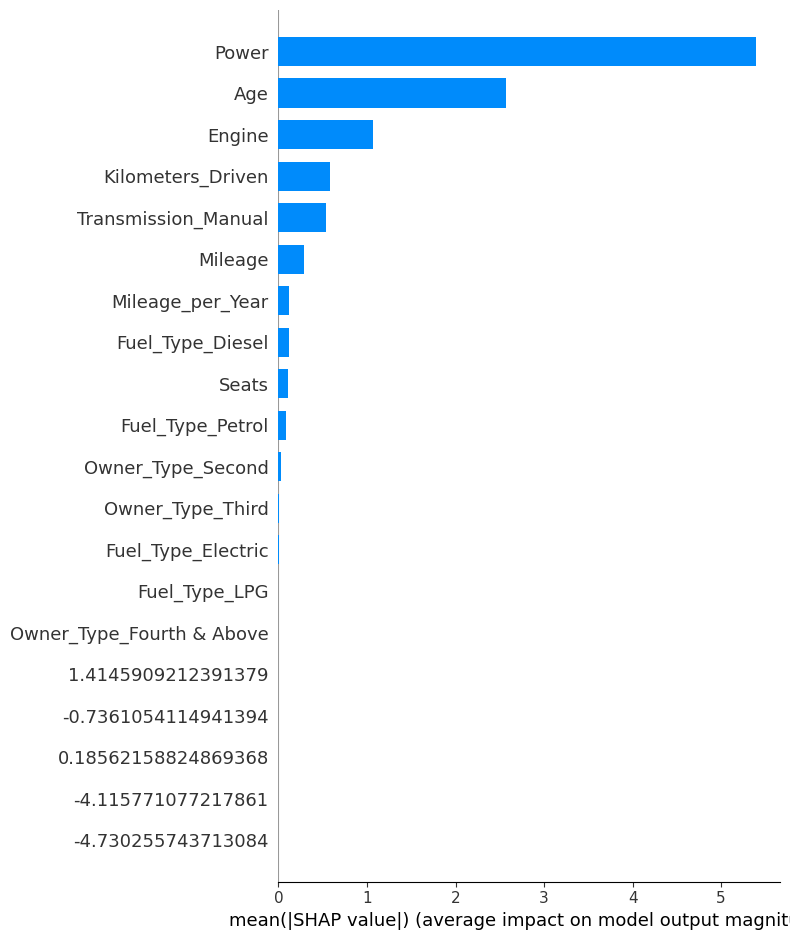

In [75]:
# Fit the model on the entire dataset for SHAP values
model_shap = RandomForestRegressor(n_estimators=100, random_state=42)
model_shap.fit(X, y)

# Calculate SHAP values
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X, plot_type="bar")

# Detailed SHAP plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

## Cell 24: Hyperparameter Tuning for XGBoost

In [77]:
# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize the model
xgb_model = XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
print(f"Best parameters for XGBoost: {best_params_xgb}")

# Train the model with the best parameters
best_xgb_model = XGBRegressor(**best_params_xgb, random_state=42)
best_xgb_model.fit(X_train, y_train)
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model - MAE: {mae_xgb}, MSE: {mse_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.6}
XGBoost Model - MAE: 1.6957793754735264, MSE: 18.380590826549145, RMSE: 4.287259127525317, R2: 0.8506365454320556


## Cell 25: Prediction Visualization

Loaded Model - MAE: 6.016079734219269, MSE: 134.82285357142857, RMSE: 11.611324367677813, R2: -0.09559085201166084


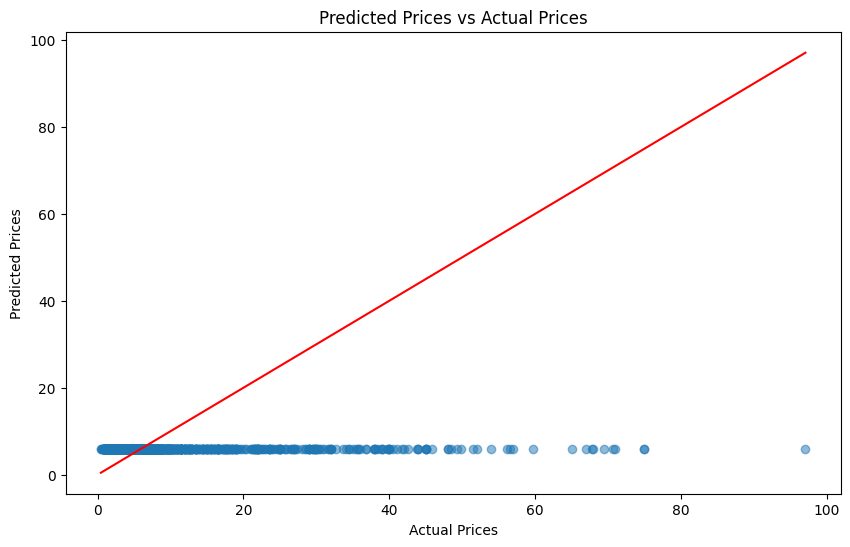

In [78]:
# Ensure the features used during training are consistent
def preprocess_features_for_model(X, model_columns):
    # Ensure the correct dummy columns are added
    X = pd.get_dummies(X)
    X = X.reindex(columns=model_columns, fill_value=0)
    return X

# Load the best Random Forest model and feature names
pipeline_with_columns = joblib.load('best_rf_model_with_columns.pkl')
loaded_pipeline, loaded_columns = pipeline_with_columns

# Ensure loaded_columns is 1-dimensional
loaded_columns = loaded_columns.tolist()

# Preprocess the test data to match the training features
X_test_preprocessed = preprocess_features_for_model(X_test, loaded_columns)

# Verify the loaded model
y_pred = loaded_pipeline.predict(X_test_preprocessed)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Loaded Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.title('Predicted Prices vs Actual Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

## Cell 26: Residual Analysis

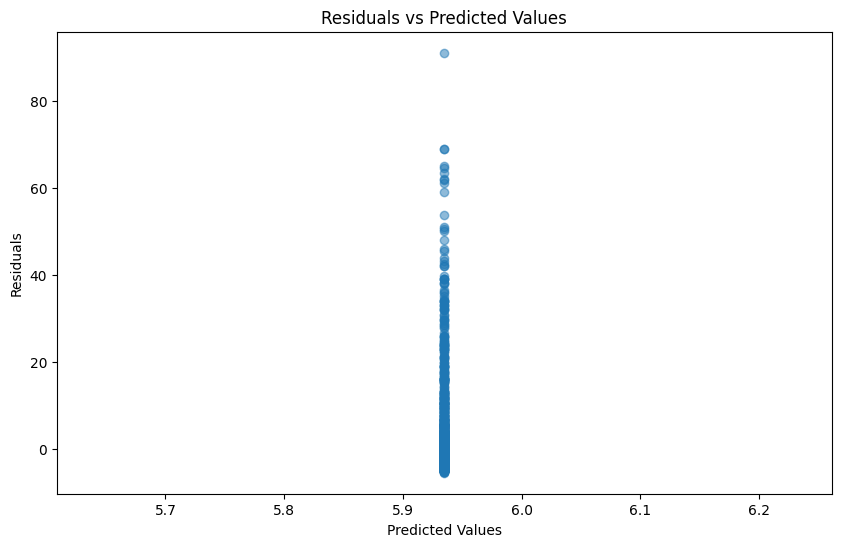

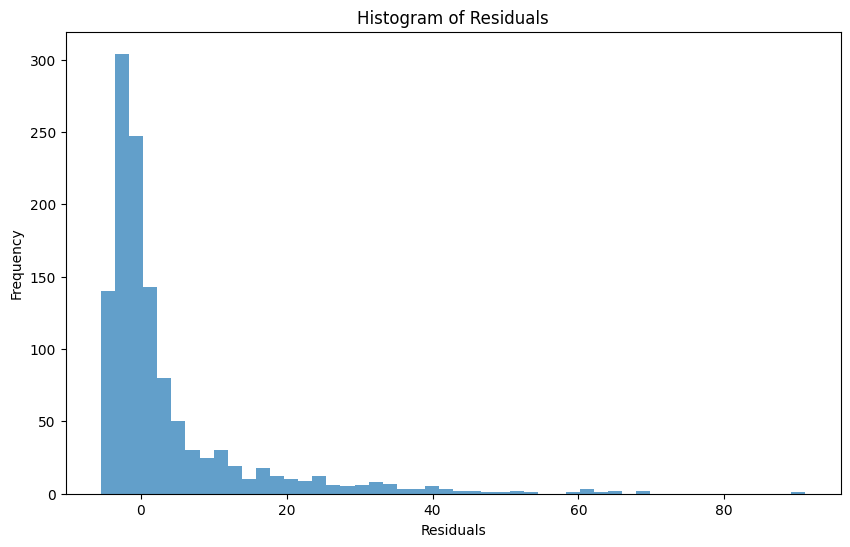

In [79]:
# Residual analysis for the best model (Random Forest in this case)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='red')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Cell 27: Advanced Feature Engineering

In [80]:
# Creating polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the polynomial features data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train a model on the polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_poly)
y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate the polynomial features model
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)

print(f"Polynomial Features Model - MAE: {mae_poly}, MSE: {mse_poly}, RMSE: {rmse_poly}, R2: {r2_poly}")

Polynomial Features Model - MAE: 3.7238407658869255, MSE: 1991.377046886117, RMSE: 44.62484786401089, R2: -15.182230368819127


## Cell 28: Cross-Validation with Polynomial Features

In [81]:
# Evaluate Linear Regression with polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

lr_poly = LinearRegression()
lr_mean_rmse_poly, lr_std_rmse_poly = evaluate_model(lr_poly, X_train_poly, y_train_poly)
print(f"Linear Regression with Polynomial Features: Mean RMSE = {lr_mean_rmse_poly:.2f}, Std RMSE = {lr_std_rmse_poly:.2f}")

Linear Regression with Polynomial Features: Mean RMSE = 4.50, Std RMSE = 0.70


## Cell 29: Save and Load Best XGBoost Model

In [82]:
# Save the best XGBoost model
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

# Load the best XGBoost model
loaded_xgb_model = joblib.load('best_xgb_model.pkl')

# Verify the loaded model
y_pred_loaded_xgb = loaded_xgb_model.predict(X_test)
mae_loaded_xgb = mean_absolute_error(y_test, y_pred_loaded_xgb)
print(f"Loaded XGBoost Model - MAE: {mae_loaded_xgb}")

Loaded XGBoost Model - MAE: 1.6957793754735264


## Cell 30: Model Validation and Tuning (Cross-Validation)

In [83]:
# Clean and scale the data
def clean_and_scale_data(X, y):
    X_cleaned = X.copy()
    y_cleaned = y.copy()

    # Apply log transformation to the target variable
    y_cleaned_log = np.log1p(y_cleaned)

    # Scale the features
    scaler = StandardScaler()
    X_cleaned_scaled = scaler.fit_transform(X_cleaned)

    return X_cleaned_scaled, y_cleaned_log, scaler

# Clean and scale the training data
X_train_cleaned_scaled, y_train_cleaned_log, _ = clean_and_scale_data(X_train, y_train)

# Function to evaluate model using cross-validation
def evaluate_model_cv(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()

# Initialize models
models_cleaned = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Evaluate Linear Regression
lr_mean_rmse, lr_std_rmse = evaluate_model_cv(models_cleaned['Linear Regression'], X_train_cleaned_scaled, y_train_cleaned_log)
print(f"Linear Regression: Mean RMSE = {lr_mean_rmse:.2f}, Std RMSE = {lr_std_rmse:.2f}")

# Evaluate Random Forest
rf_mean_rmse, rf_std_rmse = evaluate_model_cv(models_cleaned['Random Forest'], X_train_cleaned_scaled, y_train_cleaned_log)
print(f"Random Forest: Mean RMSE = {rf_mean_rmse:.2f}, Std RMSE = {rf_std_rmse:.2f}")

# Evaluate XGBoost
xgb_mean_rmse, xgb_std_rmse = evaluate_model_cv(models_cleaned['XGBoost'], X_train_cleaned_scaled, y_train_cleaned_log)
print(f"XGBoost: Mean RMSE = {xgb_mean_rmse:.2f}, Std RMSE = {xgb_std_rmse:.2f}")

Linear Regression: Mean RMSE = 0.27, Std RMSE = 0.01
Random Forest: Mean RMSE = 0.20, Std RMSE = 0.01
XGBoost: Mean RMSE = 0.20, Std RMSE = 0.01


## Cell 31: Predict Future Prices for the Next 5 Years New

In [89]:
# Check if 'Age' column is created
if 'Age' not in data.columns:
    if 'Year' in data.columns:
        data['Age'] = 2024 - data['Year']

# Select a car from the dataset
car_index = 0  # Index of the car to predict (0 to select the first car, change as needed)
car_features = X_test.iloc[car_index].copy()

# Load the best Random Forest model and its feature columns
loaded_pipeline, loaded_columns = joblib.load('best_rf_model_with_columns.pkl')

# Predict the price for the current features
car_features_df = pd.DataFrame([car_features]).reindex(columns=loaded_columns, fill_value=0)
current_predicted_price = loaded_pipeline.predict(car_features_df)[0]
print(f"Current predicted price: {current_predicted_price}")

# Flatten y_test
y_test_flat = y_test.flatten()

# Function to predict future prices
def predict_future_prices(car_features, model, columns, years=5):
    predictions = []
    original_age = car_features['Age']  # Assuming 'Age' is now created
    original_km_driven = car_features['Kilometers_Driven']

    for i in range(1, years + 1):
        # Increment the 'Age' of the car by 1 year
        car_features['Age'] = original_age + i
        # Assume an additional 10,000 km driven each year (adjust as needed)
        car_features['Kilometers_Driven'] = original_km_driven + (10000 * i)
        # Recalculate 'Mileage_per_Year'
        car_features['Mileage_per_Year'] = car_features['Kilometers_Driven'] / car_features['Age']

        # Ensure the features used during training are consistent
        car_features_df = pd.DataFrame([car_features]).reindex(columns=columns, fill_value=0)

        # Debugging: print the updated car features for verification
        print(f"Year {i}: Age = {car_features['Age']}, Kilometers_Driven = {car_features['Kilometers_Driven']}, Mileage_per_Year = {car_features['Mileage_per_Year']}")

        # Predict the price
        predicted_price = model.predict(car_features_df)[0]
        predictions.append(predicted_price)

    return predictions

# Predict future prices
future_prices = predict_future_prices(car_features, loaded_pipeline, list(loaded_columns))

# Display the original price and the predicted prices for the next 5 years
original_price = y_test_flat[car_index]
print(f"Original price: {original_price}")
print(f"Predicted prices for the next 5 years: {future_prices}")

# Plot the predicted prices
years = list(range(1, 6))
plt.figure(figsize=(10, 6))
plt.plot(years, future_prices, marker='o')
plt.title('Predicted Car Prices for the Next 5 Years')
plt.xlabel('Years from Now')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

ValueError: Index data must be 1-dimensional